In [1]:
import cv2
import numpy as np
import json
import scipy.signal

import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

with open("iref_trim_per_module.json", "r") as f:
    data = json.load(f)

# Nombre de fils prévu

In [2]:
# Extraire le numéro de série d'un module depuis le nom du fichier

def extract_serial_number (file_name) :
    names = file_name.split("_")
    for x in names :
        if "20UPGM" in x :
            return (x)
    return (None)

In [3]:
# Lire les bits iref codés dans le json

def iref_trim (serialNumber, data) :
    ok = False
    for x in data :
        if x['serialNumber'] == serialNumber :
            iref = x
            ok = True
    assert ok, "serialNumber not found"
    return (iref['IREF_TRIM_1'], iref['IREF_TRIM_2'], iref['IREF_TRIM_3'], iref['IREF_TRIM_4'])

In [4]:
# Donner le nombre de fils attendus pour un certain module

def expected_wire_number (serialNumber, data) :
    iref = iref_trim(serialNumber, data)
    nb_wire_per_trim = [4, 3, 3, 2, 3, 2, 2, 1, 3, 2, 2, 1, 2, 1, 1, 0]
    return (693 + nb_wire_per_trim[iref[0]] + nb_wire_per_trim[iref[1]] + nb_wire_per_trim[iref[2]] + nb_wire_per_trim[iref[3]])

# Comptage du nombre de fils réel

In [95]:
# Définir une zone verticale de recherche de fils (entre high et low)

def crop_lignes (image_grey) :
    image_bw = cv2.threshold(image_grey, 127,255,cv2.THRESH_BINARY_INV)[1]
    n = image_bw.shape[0]
    limit_high = 0
    x = image_bw[limit_high].mean()
    while (limit_high < n//2) and (x <= 170) :
        limit_high+=1
        x = image_bw[limit_high].mean()
    limit_low = n-1
    x = image_bw[limit_low].mean()
    while (limit_low > n//2) and (x <= 170) :
        limit_low-=1
        x = image_bw[limit_low].mean()
    return (limit_high + 25, limit_low - 42)

In [57]:
# Compter le nombre de fils à gauche et à droite

def count (image_grey_crop, column_left, column_right) :
    peaks_left, _ = scipy.signal.find_peaks(image_grey_crop[:,column_left], distance=3, prominence=50, height=190, width=(0,9))
    peaks_right, _ = scipy.signal.find_peaks(image_grey_crop[:,column_right], distance=3, prominence=50, height=190, width=(0,9))
    return (peaks_left.shape[0], peaks_right.shape[0])

In [7]:
def crop_colonnes (image_grey_crop, level = 100) :
    n = image_grey_crop.shape[1]
    left = 0
    right = n-1
    count_left, count_right = count(image_grey_crop, left, right)
    while ((count_left < level) or (count_right < level)) and (left < n) and (right > 0) :
        if (count_left < level) :
            left += 1
        if (count_right < level) :
            right -= 1
        count_left, count_right = count(image_grey_crop, left, right)
    return (left, right)

In [8]:
def crop (image_grey) :
    high, low = crop_lignes(image_grey)
    grey_cropped_lignes = image_grey[high:low]
    left, right = crop_colonnes(grey_cropped_lignes)
    return (high, low, left, right)

In [9]:
# Dire si un module a le bon nombre de fils

def test_wire_number (file_name, data) :
    expected_nb = expected_wire_number(extract_serial_number(file_name), data)
    image = cv2.imread("ModulePictures/" + file_name)
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    high, low, left, right = crop(grey)
    grey_crop = grey[high:low]
    real_nb_left, real_nb_right = count(grey_crop, column_left = left+35, column_right = right-35)
    real_nb = real_nb_left + real_nb_right
    return (expected_nb == real_nb, expected_nb, real_nb)

In [65]:
# Donner la position des fils trouvés

def wire_pos (image) :
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    high, low, left, right = crop(grey)
    grey_crop = grey[high:low]
    peaks_left, _ = scipy.signal.find_peaks(grey_crop[:,left+35], distance=3, prominence=50, height=190, width=(0,9))
    peaks_right, _ = scipy.signal.find_peaks(grey_crop[:,right-35], distance=3, prominence=50, height=190, width=(0,9))
    return(peaks_left + high, left+35, peaks_right + high, right-35)

# Tests

In [11]:
# Création des différents jeux de test

fichiers = [f for f in listdir("ModulePictures") if isfile(join("ModulePictures", f))]
fichiersOK = []
fichiersNOK = []

for x in fichiers :
    if not("NoLight" in x) and not("GA4" in x) :
        if "NOK" in x:
            fichiersNOK.append(x)
        else :
            fichiersOK.append(x)

len(fichiersOK), len(fichiersNOK)

(10, 24)

In [91]:
# TEST sur les modules OK

columns_left = [740, 750, 800, 780, 830, 800, 890, 890, 740, 830]
columns_right = [6130, 6080, 6130, 6110, 6140, 6100, 6210, 6210, 6050, 6150]

for x in fichiersOK :
    print(test_wire_number(x, data))

# ATTENTION : P1024_20UPGM23211820_AfterWirebonding.jpg
# pb à 900 à cause d'un petit point blanc !!

(True, 700, 700)
(True, 700, 700)
(True, 699, 699)
(True, 701, 701)
(True, 701, 701)
(True, 700, 700)
(True, 698, 698)
(True, 700, 700)
(True, 697, 697)
(True, 700, 700)


In [ ]:
for x in fichiersNOK :
    print(test_wire_number(x, data))

# 20UPGM23211132_PPPV2_43_AfterBonding_NOK.jpg : 1 plus en bas à droite
# P1002_20UPGM23211221_AfterBonding_NOK.jpg : 1 plus en haut à gauche + 1 plus en bas à droite
# P1003_20UPGM23211222_AfterBonding_NOK.jpg : 1 moins en bas à droite
# P1005_20UPGM23211816_AfterBonding_NOK.jpg : 1 plus en haut à droite
# P1009_20UPGM23210964_AfterWirebonding_NOK.jpg : 1 moins en bas à droite
# P1028_20UPGM23211424_AfterBonding_NOK.jpg : 1 moins en bas à gauche


(True, 698, 698)
(True, 700, 700)
(False, 701, 700)
(False, 703, 701)
(False, 702, 704)
(True, 701, 701)
(True, 702, 702)
(True, 702, 702)
(True, 701, 701)
(True, 700, 700)
(False, 700, 699)
(True, 700, 700)
(False, 700, 685)
(False, 702, 687)
(True, 701, 701)
(False, 698, 696)
(False, 702, 704)
(False, 696, 692)
(True, 700, 700)
(False, 701, 699)
(True, 701, 701)
(True, 701, 701)
(False, 701, 700)
(True, 700, 700)


In [14]:
fichiersOK

['20UPGM23211355_PPPV2_46_AfterBonding.jpg',
 'P1008_20UPGM23210595_AfterWirebonding.jpg',
 'P1014_20UPGM23211689_AfterWirebonding.jpg',
 'P1015_20UPGM23210321_AfterWirebonding.jpg',
 'P1017_20UPGM23211308_AfterWirebonding.jpg',
 'P1018_20UPGM23211497_AfterWirebonding.jpg',
 'P1023_20UPGM23211432_AfterWirebonding.jpg',
 'P1024_20UPGM23211820_AfterWirebonding.jpg',
 'P1027_20UPGM23211441_AfterBonding.jpg',
 'P1033_20UPGM23211444_AfterBonding.jpg']

In [15]:
fichiersNOK

['20UPGM23210250_PPPV2_45_AfterBonding_NOK.jpg',
 '20UPGM23211132_PPPV2_43_AfterBonding_NOK.jpg',
 '20UPGM23211273_PPPV2_44_AfterBonding_NOK.jpg',
 '20UPGM23211356_PPPV2_47_AfterBonding_NOK.jpg',
 'P1002_20UPGM23211221_AfterBonding_NOK.jpg',
 'P1003_20UPGM23211222_AfterBonding_NOK.jpg',
 'P1004_20UPGM23211223_AfterBonding_NOK.jpg',
 'P1005_20UPGM23211816_AfterBonding_NOK.jpg',
 'P1006_20UPGM23210571_AfterBonding_NOK.jpg',
 'P1007_20UPGM23210111_AfterWirebonding_NOK.jpg',
 'P1009_20UPGM23210964_AfterWirebonding_NOK.jpg',
 'P1010_20UPGM23210110_AfterBonding_NOK.jpg',
 'P1011_20UPGM23210962_AfterWirebonding_NOK.jpg',
 'P1012_20UPGM23210593_AfterWirebonding_NOK.jpg',
 'P1013_20UPGM23211571_AfterWirebonding_NOK.jpg',
 'P1016_20UPGM23210323_AfterWirebonding_NOK.jpg',
 'P1019_20UPGM23211818_AfterWirebonding_NOK.jpg',
 'P1020_20UPGM23211690_AfterWirebonding_NOK.jpg',
 'P1021_20UPGM23211499_AfterWirebonding_NOK.jpg',
 'P1022_20UPGM23211429_AfterBonding_NOK.jpg',
 'P1025_20UPGM23210676_AfterBond

In [114]:
image = cv2.imread('ModulePictures/P1029_20UPGM23210497_AfterBonding_NOK.jpg')
image2 = image.copy()
test_left, left, test_right, right = wire_pos(image)
for x in test_left :
    image2[x, left] = [0, 0, 0]
for x in test_right :
    image2[x, right] = [0, 0, 0]

cv2.imwrite('test.jpg',image2)

True

In [16]:
for i in range(len(fichiersOK)) :
    image = cv2.imread('ModulePictures/'+fichiersOK[i])
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print(crop (grey))

(153, 5322, 714, 6157)
(163, 5351, 728, 6110)
(157, 5339, 776, 6156)
(149, 5326, 754, 6135)
(165, 5340, 794, 6172)
(165, 5332, 776, 6153)
(146, 5318, 860, 6246)
(160, 5321, 856, 6249)
(197, 5369, 706, 6091)
(222, 5360, 793, 6179)


# Tests plus poussés sur un module particulier

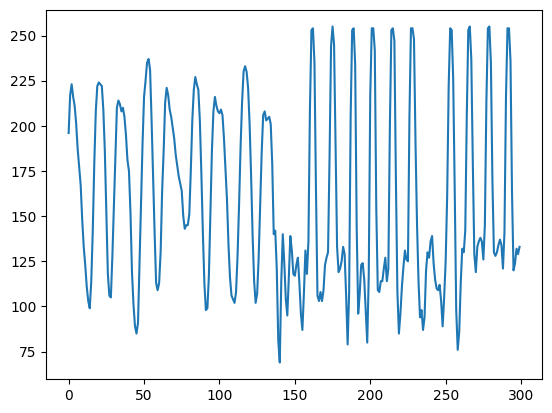

In [17]:
image = cv2.imread('ModulePictures/20UPGM23211355_PPPV2_46_AfterBonding.jpg')
left = 740
right = 6130
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
n = grey.shape[0]
plt.plot(np.arange(grey.shape[0])[:300], grey[:,left][:300])

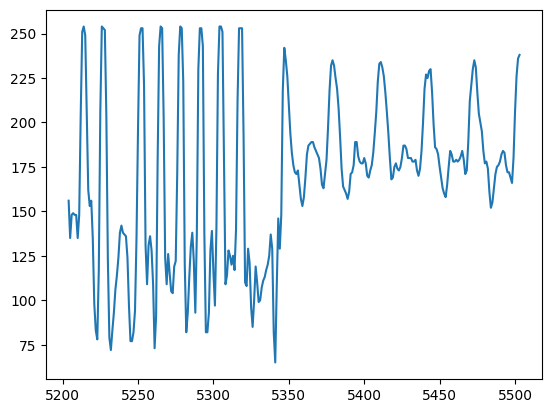

In [18]:
plt.plot(np.arange(grey.shape[0])[n-300:], grey[:,right][n-300:])

In [19]:
high, low = crop_lignes(image)
image_crop = image[high:low]

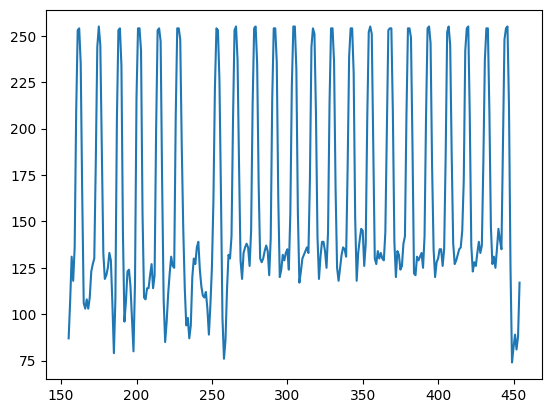

In [20]:
plt.plot(np.arange(low-high)[:300]+high, grey[high:low,left][:300])

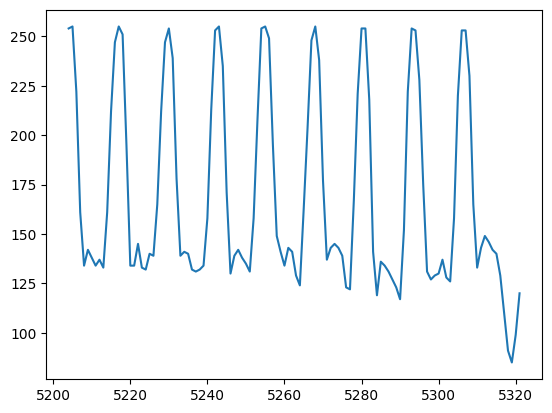

In [21]:
plt.plot(np.arange(low-high)[n-high-300:]+high, grey[high:low,left][n-high-300:])